In [15]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score

# 딥러닝 모델 (TensorFlow)
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [16]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [17]:
categorical_cols = ["주거 형태", "현재 직장 근속 연수", "대출 목적", "대출 상환 기간"]

# 라벨 인코딩 (현재 직장 근속 연수)
label_enc = LabelEncoder()
X["현재 직장 근속 연수"] = label_enc.fit_transform(X["현재 직장 근속 연수"])
test_df["현재 직장 근속 연수"] = label_enc.transform(test_df["현재 직장 근속 연수"])

# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)

In [18]:
# 로그 변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for col in log_columns:
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [19]:
#결측값 처리
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

In [20]:
#데이터 scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

In [21]:
#불균형 데이터 처리
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU

# Fold별 Accuracy와 Loss 저장용 리스트 초기화
all_history = []
roc_auc_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, valid_index in kf.split(X_resampled):
    print(f"🔄 Fold {fold} 시작")

    # 학습/검증 데이터 분리
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    # 모델 정의 (BN 추가 & 최적화된 구조)
    model = keras.Sequential([
        Dense(64),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),  # Dropout 비율 조정

        Dense(32),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(1, activation="sigmoid")
    ])

    # Adam 옵티마이저 & 학습률 초기값 설정
    optimizer = Adam(learning_rate=5e-5)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # 학습률 감소 콜백 추가
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,  # 학습률을 절반으로 줄임
        patience=5,  # 5 epoch 동안 개선 없으면 감소
        min_lr=1e-6,  # 최소 학습률 설정 (너무 작아지는 것 방지)
        verbose=1
    )

    # 조기 종료 콜백 설정
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=5e-5,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_valid_fold, y_valid_fold),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],  # 학습률 조정 콜백 추가
        verbose=1
    )

    # Fold의 학습 결과 저장
    all_history.append(history.history)

    # 검증 데이터 예측 및 평가
    y_valid_pred = model.predict(X_valid_fold).flatten()
    y_valid_pred = np.clip(y_valid_pred, 1e-7, 1 - 1e-7)  # 값 안정화

    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"✅ Fold {fold} Validation ROC-AUC: {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)

    fold += 1

# 교차검증 평균 결과 출력
print(f"✅ 교차검증 평균 ROC-AUC: {np.mean(roc_auc_scores):.4f}")

🔄 Fold 1 시작
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4702 - loss: 0.9211 - val_accuracy: 0.4898 - val_loss: 0.8116 - learning_rate: 5.0000e-05
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4943 - loss: 0.8649 - val_accuracy: 0.5080 - val_loss: 0.7560 - learning_rate: 5.0000e-05
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5097 - loss: 0.8200 - val_accuracy: 0.5451 - val_loss: 0.7162 - learning_rate: 5.0000e-05
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5294 - loss: 0.7708 - val_accuracy: 0.5895 - val_loss: 0.6869 - learning_rate: 5.0000e-05
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5460 - loss: 0.7451 - val_accuracy: 0.6161 - val_loss: 0.6664 - learning_rate: 5.0000e-05
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5764 - loss: 0.7144 - val_accuracy: 0.6369 - val_loss: 0.6538 - learning_rate: 5.0000e-05
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

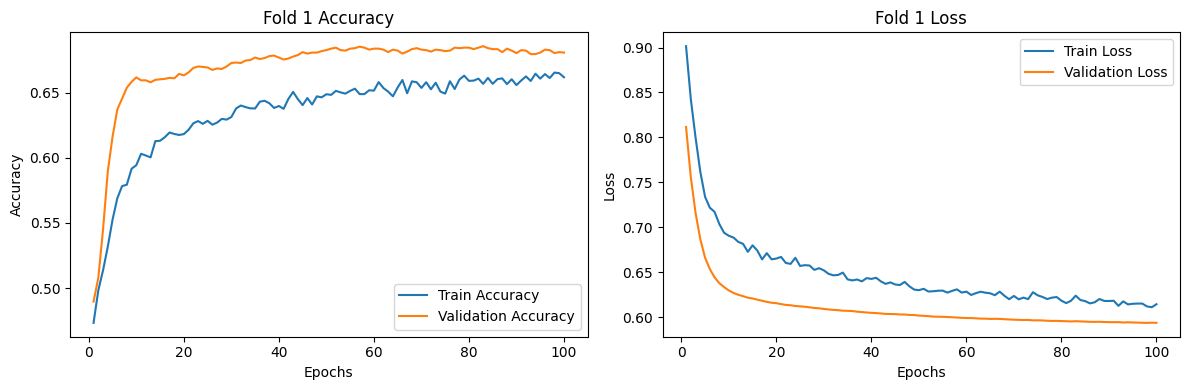

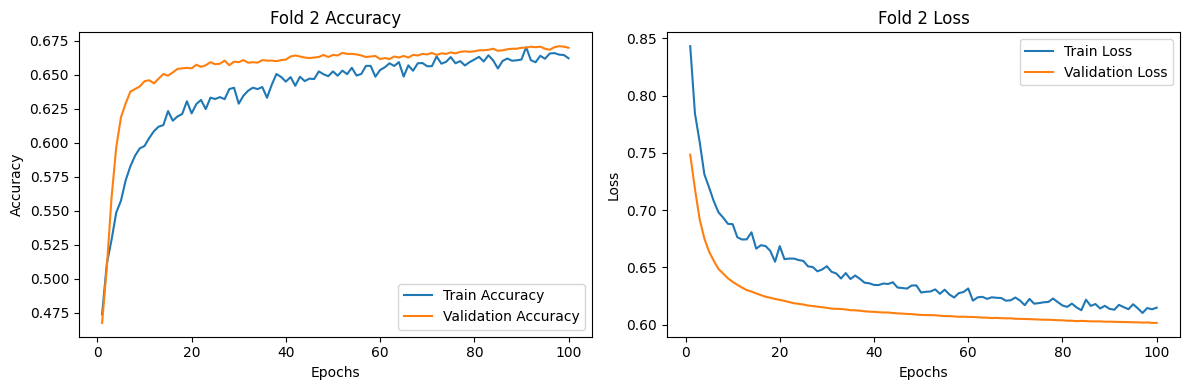

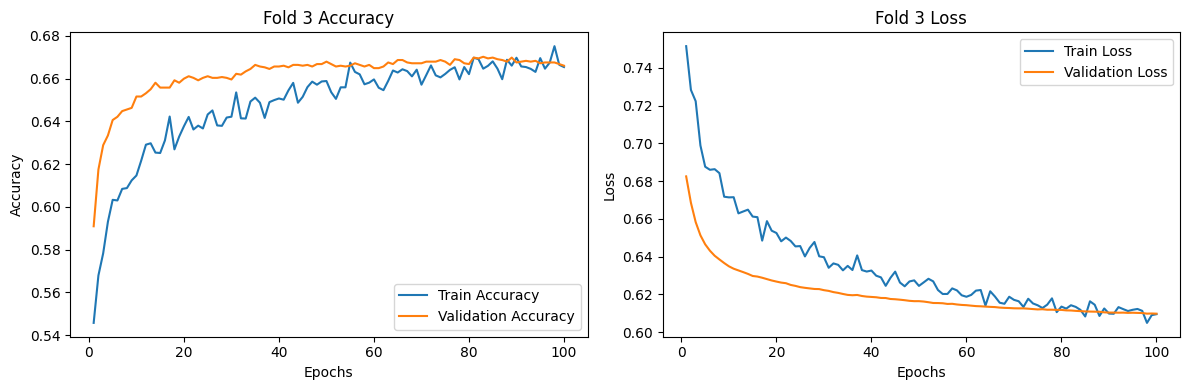

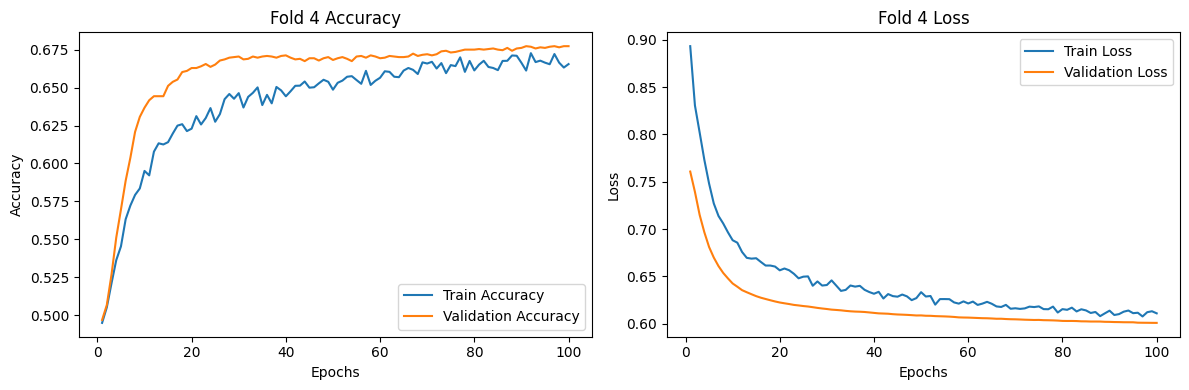

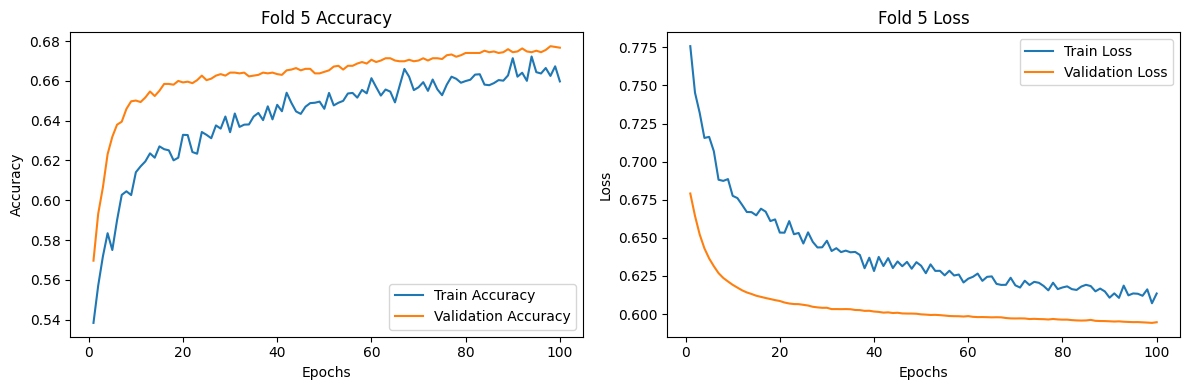

In [31]:
# 시각화: Fold별 Accuracy와 Loss
for i, history in enumerate(all_history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [32]:
y_test_pred = model.predict(test_scaled).flatten()  # 확률 값 그대로 사용

preds_series = pd.Series(y_test_pred)
print(preds_series.head())

# 제출 파일 생성
submission = pd.DataFrame({
    "UID": test_uid["UID"],
    "채무 불이행 확률": y_test_pred  # 확률값을 그대로 저장
})

# CSV 저장
submission.to_csv(r'g:\f_obligation\f_obligation_18_DL.csv', index=False)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
0    0.534935
1    0.409083
2    0.430543
3    0.309992
4    0.481108
dtype: float32
